In [1]:
import os
from eval_model import get_model_structure
from plotting.combine_results import find_files
import numpy as np
from utils.inference_utils import load_names, load_observed, load_data_non_memmaped
from plotting.plot_utils_bpaitac import histogram
from utils.region_identification_utils import get_trial_metrics, identify_regions, summary_stats
import pandas as pd
from utils.load_model import get_model, get_predictions, load_model
import scipy
import matplotlib.pyplot as plt

Selected GPU: 1
DEVICE is cuda:1


## Gather data

In [2]:
eval_set = 'test'
info_path = 'example_data/data_config.yaml'
peak_names = load_observed(info_path, eval_set, data_name='peak_names')
onehot_encoding = load_observed(info_path, eval_set, data_name= 'onehot')
cell_names = np.load("example_data/cell_names.npy")
lineage_filepath = 'example_data/immgen_lineages.csv'




Loading file: example_data/test_peak_names.npy
Loading file: example_data/test_onehot.npy


## Load model

In [ ]:
from models.AttributionModelWrapper import AttributionModelWrapper
from models.modules import AverageWrapper

model_path = 'trained_models/06-16-2025.12.17/best_model'

model_type = 'bpAITAC'
n_celltypes = 90
n_filters = 300
bin_size= 1
bin_pooling_type = None
scalar_head_fc_layers = 1
model_structure = get_model_structure(model_type, n_filters, n_celltypes)

model = load_model(model_path, model_structure=get_model_structure('bpAITAC', n_filters, n_celltypes), n_filters=n_filters, verbose=True)




199
39
7
199
39
7
DEVICE is cuda:1
998 300 90
MODEL STRUCTURE bpAITAC(
  (body): Body(
    (net): Sequential(
      (0): Conv1d(4, 300, kernel_size=(25,), stride=(1,), padding=same)
      (1): DialatedConvs(
        (net): Sequential(
          (0): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
              (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (1): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilation=(4,))
              (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (2): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same,

We must wrap the model to only produce the scalar accessibility outputs, instead of dual
accessibility and profile outputs, in order to determine attributions on the 
accessibility predictions

In [4]:
wrapped_model = AttributionModelWrapper(model) 

To create a cell lineage based predictor, instead of predicting all 90 celltypes, we also wrap the model to average over celltypes of the same lineage, to get a lineage predictor model

In [5]:
from utils.region_identification_utils import get_lineage_cells

lineage_names, lineage_cell_indices = get_lineage_cells(lineage_filepath, cell_names=cell_names)
lineage_model = AverageWrapper(model, lineage_cell_indices)
wrapped_lineage_model=AttributionModelWrapper(lineage_model) 

# Feature Attribution

In [6]:
from tangermeme.utils import random_one_hot
from tangermeme.deep_lift_shap import deep_lift_shap
from tangermeme.ersatz import substitute
import torch
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo
from tangermeme.ism import saturation_mutagenesis


In [7]:
def attributions(model, X, cell_idx,  attribution_type, hypothetical=True):
    """
    model: the nn.Module that we want to find the attributions of
    X: the region that we want attributions for. Numpy array of shape (1, 4, seq_len)
    attribution_type: either 'deep_lift_shap' or 'ism'
    cell_idx: an array of cells that the attributions for should be gathered. These are the indices of of cells which also index the model output tracks in the celltype dimension 
    cell_names: array of the names of the cells. the cell_idx can index cell_names to find the cell names
    hypothetical: whether the attributions returned should be hypothetical attributions: m(j) - 1/4 * average attribution over all base pairs (assuming uniform probability of other bases)

    returns :
        torch tensor of shape (len(cell_idx), 4, seq_len) which represents the attributions for each of the cells in cell_idx
        If you would like the attributions for only the bases in X, you can multiply X by the output
       
    """
    X = torch.tensor(X, dtype=torch.float32)
    print(X.shape)

    all_attributions = np.empty(shape=(len(cell_idx), X.shape[1], X.shape[2]))

    for i, cell in enumerate(cell_idx):
        if attribution_type == 'deep_lift_shap':
            X_attr_all = deep_lift_shap(model, X, target=cell, device='cpu', random_state=0, hypothetical=hypothetical)
        elif attribution_type == 'ism':
            X_attr_all = saturation_mutagenesis(model, X, target=cell, device='cpu', hypothetical=hypothetical)
        else:
            raise ValueError("Invalid attribution type. Choose 'deep_lift_shap' or 'ism'.")
        all_attributions[i] = X_attr_all
    
    return all_attributions

Here we show an example of how to find accessibility predition attributions 

In [8]:
region_idx = 5 # take an example region of DNA
lineage_idx = [9] # A list of the cell/lineage indices you would like to get attributions for
region_onehot = np.array(onehot_encoding[region_idx]) # convert from memmap -> numpy array
region_onehot = np.transpose(region_onehot, (1, 0))
region_onehot_expanded = np.expand_dims(region_onehot, axis=0)
onehot_multiplier = np.repeat(region_onehot_expanded, len(lineage_idx), axis=0) # to multiply by X_attr_all to get single existing base pair at a given region

# Get the attributions for the lineage model
attr_all = attributions(wrapped_lineage_model, region_onehot_expanded, cell_idx=lineage_idx, attribution_type='deep_lift_shap', hypothetical=True) 
attr_single = attr_all * onehot_multiplier




torch.Size([1, 4, 998])


### Plot the attributions

We can see that our toy model trained on ~100 peaks has not learned very interesting features

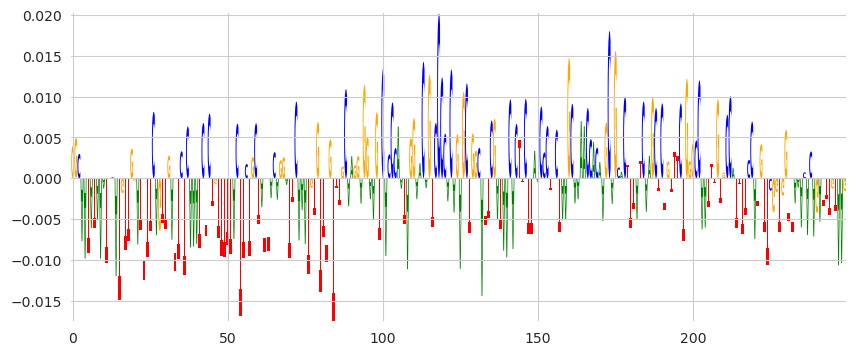

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))

# Plot just the center 250 bp (the OCR)
x_start=375
x_end=625
plot_logo(attr_single[0, :, x_start:x_end], ax1)
